In [1]:
import numpy as np
import cycler
import matplotlib.pyplot as plt
import distance as dis
import summary_statistics as sumstats
import pandas as pd
import seaborn as sns
import os
import allel
from matplotlib_venn import venn2
import msprime
import math

In [2]:
sampleSize = 40

In [37]:
os.makedirs("/home/mathieu/local/simu", exist_ok=True)
for i in range(sampleSize):
    ts = msprime.simulate(sample_size=20, Ne=140000, recombination_rate=1.53e-9, mutation_rate=1.53e-9, length=2e6)
    snp = ts.genotype_matrix().T
    pos = ts.tables.asdict()["sites"]["position"].astype(int)
    np.savez_compressed(
        f"/home/mathieu/local/simu/modA_1_{i}.npz", SNP=snp, POS=pos)

In [ ]:
%%bash
rm -rf /home/mathieu/local/toto/postgarga
cd /home/mathieu/local
mkdir /home/mathieu/local/toto/postgarga -p
for npz in toto/simu/*.npz
do
    f="$(basename -- $npz)"
    i=$(echo $f | cut -c8- | cut -d. -f1)
    #echo $i
    ./pipeline.sh -a -c 5 -l 2000000 -f $npz
    mv /home/mathieu/local/data_post_gargammel.npz /home/mathieu/local/toto/postgarga/modB_1_$i.npz
done

In [3]:
def compute_fst(fullGargaMatrix, fullSimulationMatrix):
    gar = fullGargaMatrix.T
    sim = fullSimulationMatrix.T

    g = allel.model.ndarray.HaplotypeArray(gar)
    s = allel.model.ndarray.HaplotypeArray(sim)
    ac1 = g.count_alleles()
    ac2 = s.count_alleles()

    num, den = allel.hudson_fst(ac1, ac2)
    return np.sum(num) / np.sum(den)

In [4]:
def statPostgarga(simuDir, gagaDir):
    length = 2000000
    nbdifTot = 0
    nberTot = 0
    nbsingTotsimu = 0
    nbsingTotgarga = 0
    difMatrix = []
    errMatrix = []

    totgargapos = set()
    totsimupos = set()
    fsttot = 0
    
    simuFiles = os.listdir(simuDir)
    
    for simuFileName in simuFiles:
        simuFile = simuDir + "/" + simuFileName
        gargaName = simuFileName.replace("A", "B")
        gargaFile = gagaDir + "/" + gargaName

        simudata = np.load(simuFile)
        SimulationMatrix = simudata["SNP"]
        Simulationpos = simudata["POS"]

        gargadata = np.load(gargaFile)
        gargaMatrix = gargadata["SNP"]
        gargaPos = gargadata["POS"]

        totgargapos.update(gargaPos)
        totsimupos.update(Simulationpos)

        nbdif, nber, tabdif, taber, fullSimulationMatrix, fullGargaMatrix = dis.distance(
            SimulationMatrix, gargaMatrix, Simulationpos, gargaPos, length)

        fsttot += compute_fst(fullGargaMatrix, fullSimulationMatrix)
        
        errMatrix += taber
        difMatrix += tabdif

        nbsingSimu = dis.singleton_number(SimulationMatrix)
        nbsingGarga = dis.singleton_number(gargaMatrix)

        nbdifTot += nbdif
        nberTot += nber
        nbsingTotgarga += nbsingGarga
        nbsingTotsimu += nbsingSimu

    nbsingGargaMean = nbsingTotgarga / sampleSize
    nbsingSimuMean = nbsingTotsimu / sampleSize
    nbdifMean = nbdifTot / sampleSize
    nberMean = nberTot / sampleSize
    fstMean = fsttot/ sampleSize

    print("fst : " + str(fstMean))
    print("nbdif mean : " + str(nbdifMean))
    print("nber mean : " + str(nberMean))
    print("nbsing simu mean : " + str(nbsingSimuMean))
    print("nbsing Garga mean : " + str(nbsingGargaMean))

    return totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, nbdifMean, nberMean, fstMean

In [5]:
def print_distribution(difMatrix, errMatrix):
    dif = pd.DataFrame(difMatrix, columns= ["pos"])
    err = pd.DataFrame(errMatrix, columns= ["pos"])

    tot = pd.concat([dif, err], keys=['differences', 'missing values'], names=['keys', 'RowID'])
    tot.reset_index(inplace=True)
    sns.catplot(data=tot, x = "keys",y='pos',cut = 0, kind="violin", scale = "count")
    plt.show()

In [6]:
def print_venn(totsimupos, totgargapos, axs):
    venn2([totsimupos, totgargapos], ("simu  ", "  garga"), ax = axs)

In [7]:
#sfs
def compute_sfs(datapath, length, name):
    sumstats.do_sum_stats(datapath, name, size_chr=length)

def print_normalized_sfs(sfspath, ax):
    sfs = pd.read_table(sfspath)
    ax.plot(sfs.freq_indiv, sfs.i_xi_norm)
    ax.fill_between(sfs.freq_indiv, sfs.i_xi_norm+sfs.i_xi_sem_norm,
                     sfs.i_xi_norm-sfs.i_xi_sem_norm, alpha=0.5)
    ax.axhline(1, linestyle="--", color="k")
    
def print_sfs(sfspath, ax):
    sfs = pd.read_table(sfspath)
    ax.plot(sfs.freq_indiv, sfs.i_xi)
    ax.axhline(1713, linestyle="--", color="k")

In [8]:
#LD
def plot_fill(x, y, yerr, color, ax=None, label=None, alpha=0.2, **kwargs):
    """x and y are series or numpy arrays"""
    if ax == None:
        fig, ax = plt.subplots(1, 1)

    ax.plot(x, y, color=color, label=label, **kwargs)
    ax.fill_between(x, y + yerr, y - yerr, color=color, lw=0, alpha=alpha)
    ax.set_xscale('log')

def plot_LD(ldpath, ax):
    ld = pd.read_table(ldpath)
    plot_fill(ld.mean_dist, ld.mean_r2, ld.sem_r2, "r", ax)

In [71]:
#initialise summary plot
fig, axs = plt.subplots(8,4 , figsize=(15, 25))
plt.close()

sumstatDir = "/home/mathieu/local/restest/sumstats"

In [72]:
#Simulation
simuDir = "/home/mathieu/local/restest/simu"
compute_sfs(simuDir, 2e6, "simu")
sfspath = sumstatDir +"/simu.sfs"
ldpath = sumstatDir + "/simu.ld"

In [73]:
y = 0
axs.flat[y].set(ylabel='simulation')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])

fst : 0.2394280415066968
nbdif mean : 23748.825
nber mean : 0.0
nbsing simu mean : 1794.2
nbsing Garga mean : 1701.6


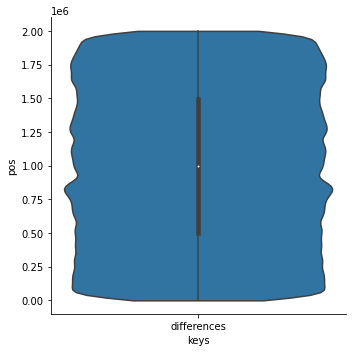

In [74]:
#1 C 1.26 / L 91
gargaDir = "/home/mathieu/local/restest/1n"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, 
nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "1n")
sfspath = sumstatDir + "/1n.sfs"
ldpath = sumstatDir +"/1n.ld"
print_distribution(difMatrix, errMatrix)

In [75]:
y = 7
axs.flat[y*4].set(ylabel='C = 1.26 / L = 91')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : 0.0008139121403475247
nbdif mean : 9168.525
nber mean : 0.0
nbsing simu mean : 1794.2
nbsing Garga mean : 1714.1


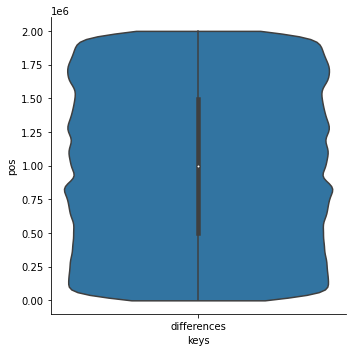

In [76]:
#2 C 2.65 L 77 
gargaDir = "/home/mathieu/local/restest/2n"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, 
 nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "2n")
sfspath = sumstatDir + "/2n.sfs"
ldpath = sumstatDir + "/2n.ld"
print_distribution(difMatrix, errMatrix)

In [77]:
y = 4
axs.flat[y*4].set(ylabel='C = 2.65 / L = 77')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : 0.04271725129353249
nbdif mean : 12830.875
nber mean : 0.0
nbsing simu mean : 1794.2
nbsing Garga mean : 1709.9


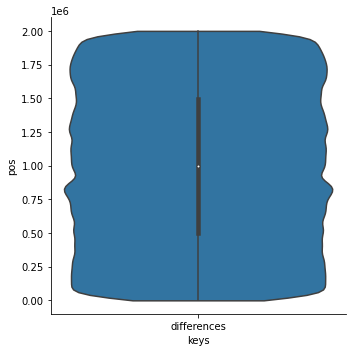

In [78]:
#3 C 2.08 L 55
gargaDir = "/home/mathieu/local/restest/3n"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, nbsingSimuMean, 
 nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "3n")
sfspath = sumstatDir + "/3n.sfs"
ldpath = sumstatDir + "/3n.ld"
print_distribution(difMatrix, errMatrix)

In [79]:
y = 5
axs.flat[y*4].set(ylabel='C = 2.08 / L = 55')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : -0.05158930459967751
nbdif mean : 355.925
nber mean : 0.0
nbsing simu mean : 1794.2
nbsing Garga mean : 1775.95


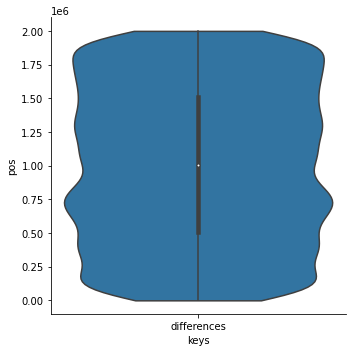

In [80]:
#4 C 6.75 L 45
gargaDir = "/home/mathieu/local/restest/4n"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "4n")
sfspath = sumstatDir + "/4n.sfs"
ldpath = sumstatDir + "/4n.ld"
print_distribution(difMatrix, errMatrix)

In [81]:
y = 2
axs.flat[y*4].set(ylabel='C = 6.75 / L = 45')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : 0.06632115547502745
nbdif mean : 14520.55
nber mean : 0.0
nbsing simu mean : 1794.2
nbsing Garga mean : 1704.325


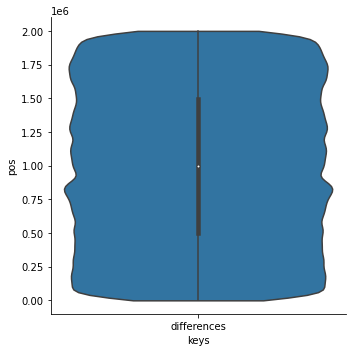

In [82]:
#5 C = 1.89 / L = 48
gargaDir = "/home/mathieu/local/restest/5n"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "5n")
sfspath = sumstatDir + "/5n.sfs"
ldpath = sumstatDir + "/5n.ld"
print_distribution(difMatrix, errMatrix)

In [83]:
y = 6
axs.flat[y*4].set(ylabel='C = 1.89 / L = 48')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : -0.05203360383569181
nbdif mean : 47.625
nber mean : 0.0
nbsing simu mean : 1794.2
nbsing Garga mean : 1788.725


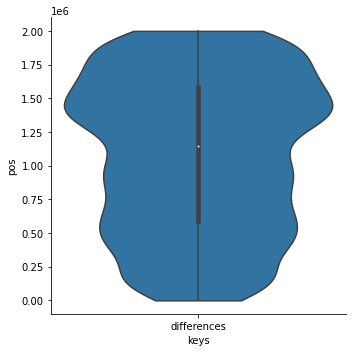

In [84]:
#6 C = 10.28 L = 44
gargaDir = "/home/mathieu/local/restest/6n"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "6n")
sfspath = sumstatDir + "/6n.sfs"
ldpath = sumstatDir + "/6n.ld"
print_distribution(difMatrix, errMatrix)

In [85]:
y = 1
axs.flat[y*4].set(ylabel='C = 10.28 L = 44')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

fst : -0.016997582449481363
nbdif mean : 7210.325
nber mean : 0.0
nbsing simu mean : 1794.2
nbsing Garga mean : 1708.825


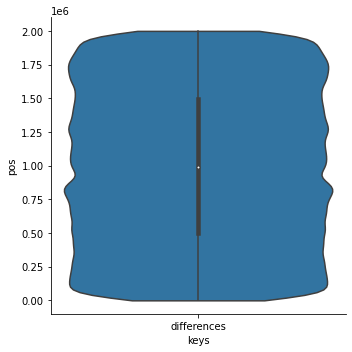

In [86]:
#7
gargaDir = "/home/mathieu/local/restest/7n"
(totgargapos, totsimupos, difMatrix, errMatrix, nbsingGargaMean, 
nbsingSimuMean, nbdifMean,nberMean, fstMean) = statPostgarga(simuDir, gargaDir)

compute_sfs(gargaDir, 2e6, "7n")
sfspath = sumstatDir + "/7n.sfs"
ldpath = sumstatDir + "/7n.ld"
print_distribution(difMatrix, errMatrix)

In [87]:
y = 3
axs.flat[y*4].set(ylabel='C = 2.91 L = 43')
plot_LD(ldpath,axs[y,0])
print_normalized_sfs(sfspath,axs[y,1])
print_sfs(sfspath,axs[y,2])
print_venn(totsimupos, totgargapos,axs[y][3])

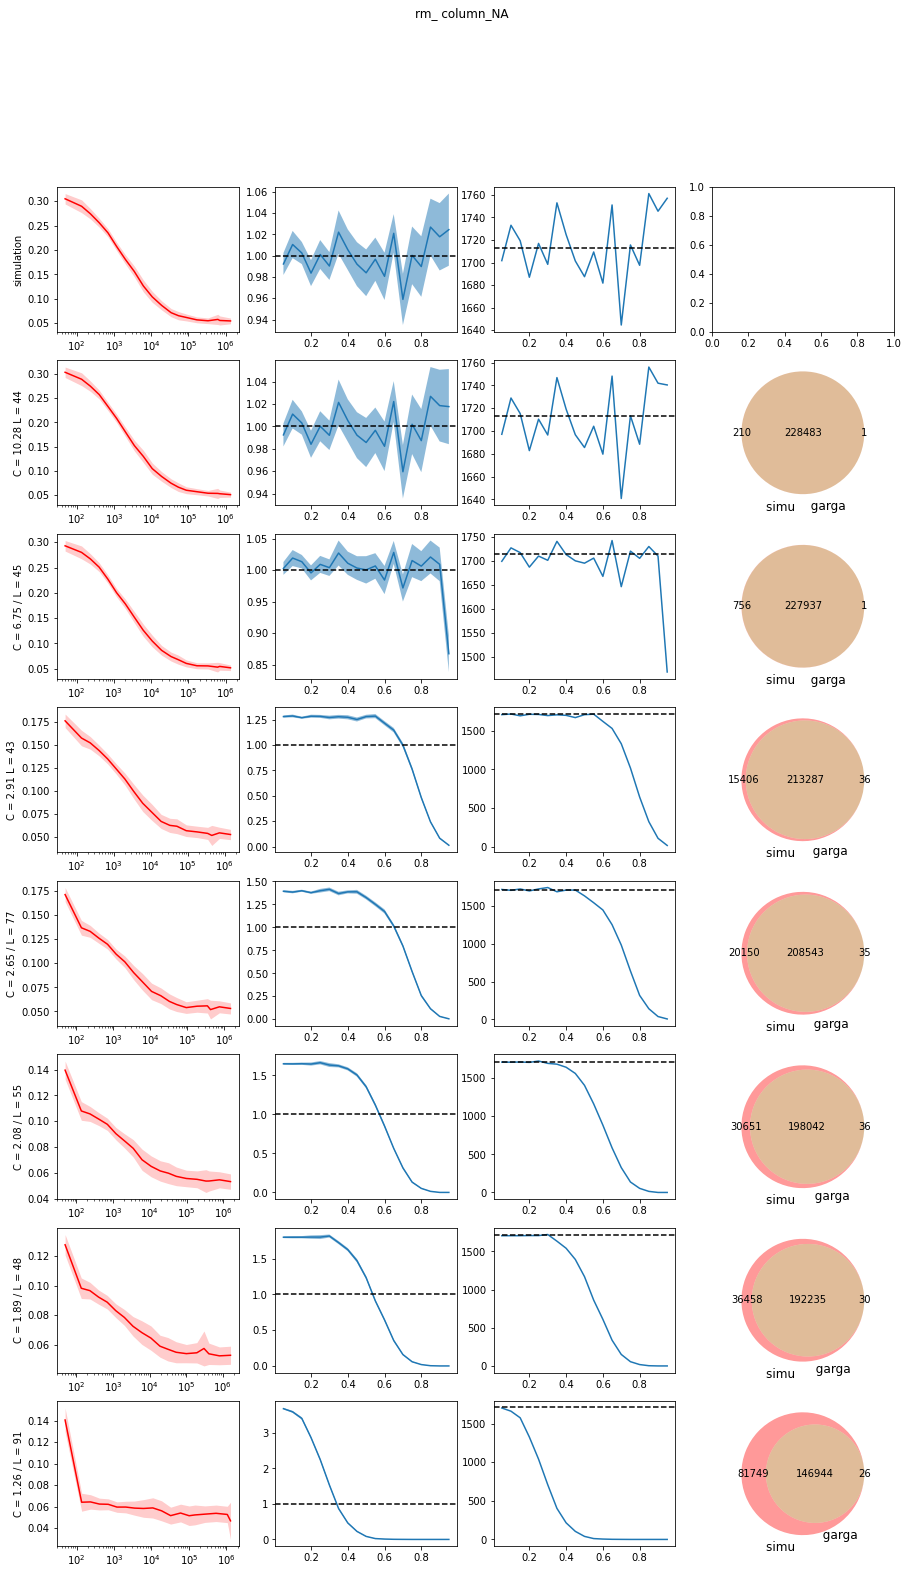

In [88]:
#Summary plot
fig.suptitle('rm_ column_NA')
fig.subplots_adjust(top= 0.88)
fig.savefig('/home/mathieu/local/restest/rm_NA.png', transparent=False)
fig